In [128]:
import os
import yfinance as yf
import pandas as pd
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import feather
import pyarrow.parquet as pq
import pyarrow as pa
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('fivethirtyeight')

In [ ]:
- Get daily pricing data
- Resample into monthly return
- Create a DF of monthly returns. The shape should be: Date,SymbolA,SymbolB
- QCut each month to assign a bucket to each symbol/column

In [94]:
df = pd.read_csv('sp100.csv',index_col=0)
tickers =  [i.replace('.','-') for i in df.Symbol.to_list()]

file = 'datasets/sp100.parquet'
if not os.path.isfile(file):
    df = yf.download(tickers,start='2005-01-01',auto_adjust=True,progress=False)
    # Or use the monthly option
    # dl = yf.download(tickers, session=session, interval='1mo', start='2005-01-01')
    df.to_parquet('datasets/sp100.parquet')
df = pd.read_parquet('datasets/sp100.parquet')
prices = df.Close
prices.index = pd.to_datetime(prices.index)
monthly_rets = prices.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)

Close                                                  \
                  AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2005-01-03    0.971844         NaN   14.956534   19.618639   30.838949   
2005-01-04    0.981825         NaN   14.805904   19.157375   30.024111   
2005-01-05    0.990424         NaN   14.636057   19.082981   29.859142   
2005-01-06    0.991192         NaN   14.966144   18.911869   29.364239   
2005-01-07    1.063362         NaN   15.222524   19.797201   29.384233   
...                ...         ...         ...         ...         ...   
2021-07-26  148.990005  117.790001  119.519997  318.980011  620.799988   
2021-07-27  146.770004  117.959999  119.809998  319.890015  618.280029   
2021-07-28  144.979996  118.550003  120.519997  316.309998  620.919983   
2021-07-29  145.639999  118.870003  121.089996  318.350006  621.700012   
2021-07-30  145.860001  116.300003  120.980003  317.679993  621.630005   

                                                                         ...  \
                   AIG        AMGN         AMT         AMZN        AVGO  ...   
Date                                                                     ...   
2005-01-03  873.705200   50.510906   15.225256    44.520000         NaN  ...   
2005-01-04  876.616089   49.709389   15.024044    42.139999         NaN  ...   
2005-01-05  891.171082   48.923599   14.889898    41.770000         NaN  ...   
2005-01-06  892.627014   49.379353   15.024044    41.049999         NaN  ...   
2005-01-07  894.214600   49.481529   15.292330    42.320000         NaN  ...   
...                ...         ...         ...          ...         ...  ...   
2021-07-26   47.709999  245.080002  284.609985  3699.820068  482.239990  ...   
2021-07-27   47.419998  244.679993  286.880005  3626.389893  475.359985  ...   
2021-07-28   46.950001  244.250000  284.980011  3630.320068  477.649994  ...   
2021-07-29   47.869999  242.460007  283.000000  3599.919922  484.109985  ...   
2021-07-30   47.349998  241.539993  282.799988  3327.590088  485.399994  ...   

             Volume                                                            \
                UNH      UNP       UPS      USB          V        VZ      WBA   
Date                                                                            
2005-01-03  6252600  7762400   2176500  5374600        NaN   9236061  9757800   
2005-01-04  5582000  8108400   3127400  4552700        NaN  11680234  6618200   
2005-01-05  4577600  5504800   2130700  5701600        NaN   8201616  6850200   
2005-01-06  4837600  5653600   1773600  4203000        NaN   7844458  4816400   
2005-01-07  6653200  3998000   2396900  5312700        NaN   8424450  2946400   
...             ...      ...       ...      ...        ...       ...      ...   
2021-07-26  2232600  2840900   2673700  3721700  4879000.0  15330500  4056600   
2021-07-27  2630600  3199000  13741500  4332400  7038300.0  15225800  5121300   
2021-07-28  2446600  2366200   6295500  4063600  9036500.0  14595900  3333800   
2021-07-29  1597300  1908000   3150300  7566000  7495300.0  12841900  3084600   
2021-07-30  1864200  2323500   3740300  6478400  5804200.0  13853500  9694300   

                                          
                 WFC       WMT       XOM  
Date                                      
2005-01-03   8168200  16078400  16009200  
2005-01-04   9241400  10596700  16718000  
2005-01-05   7694600   8241500  12189100  
2005-01-06   8887600  14028800  13098700  
2005-01-07   6573200   9660300  11315300  
...              ...       ...       ...  
2021-07-26  22976700   6172400  18387600  
2021-07-27  22124500   5131900  16861400  
2021-07-28  23252800   4690500  16855300  
2021-07-29  24487400   3687700  18607800  
2021-07-30  25792500   5441700  28641900  

[4173 rows x 505 columns]

In [84]:
# Make a data frame with prior months as a column
formation_dt = dt.datetime(2021,7,31)
prior_monthly_rets = pd.DataFrame({'returns':monthly_rets.loc[formation_dt - MonthEnd(1)]})

# Bucket returns - This works for a single month
prior_monthly_rets['decile'] = pd.qcut(prior_monthly_rets.returns, 20, labels=False)
losers = prior_monthly_rets[prior_monthly_rets.decile == 0].index
losers_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(losers)].mean()
losers_ret

In [122]:
# Create a DF of monthly returns for each qtile using melt
# DF should be monthly end date, symbol1, symbol2
def melting(monthly_rets, bins):
    monthly_rets = monthly_rets.dropna()
    monthly_qtiles = monthly_rets.apply(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop'), axis=1)
    df0 = monthly_qtiles.melt(ignore_index=False)
    df0.columns = ['symbol', 'qtile']
    df1 = monthly_rets.melt(ignore_index=False)
    df1.columns = ['symbol', 'pchange']
    df = pd.merge(left=df0, right=df1, on=['Date', 'symbol'])
    df.reset_index(inplace=True)
    df['date_prev'] = df.Date - MonthEnd(1)
    df = pd.merge(left=df, right=df[['date_prev', 'symbol', 'pchange', 'qtile']], left_on=['Date', 'symbol'], right_on=['date_prev', 'symbol'], suffixes=[None,'_prev'])    
    #pdf = pd.pivot_table(df, index='Date', columns='qtile', values='pchange', aggfunc=np.mean)
    #df.groupby(['Date', 'qtile'])['pchange'].mean()
    return df

# WIP
def dog_strategy(monthly_rets, bin_idx, total_bins):
    pdf, df = melting(monthly_rets, total_bins)
    df['date_prev'] = df.Date - MonthEnd(1)
    xdf = pd.merge(left=df, right=df[['date_prev', 'symbol', 'returns', 'qtile']], left_on=['Date', 'symbol'], right_on=['date_prev', 'symbol'], suffixes=[None,'_prev'])
    returns = pd.pivot_table(xdf, index='Date', columns='qtile_prev', values='returns', aggfunc=np.mean)
    symbols = df[(df.Date == '2021-01-31') & (df.qtile == bin_idx)].symbol.values.tolist()
    df[ (df.Date == '2021-02-28') & (df.symbol.isin(symbols)) ]['returns'].mean()


In [ ]:
# The method used in the video
def monthly_decile(formation_dt, decile, monthly_rets):
    df = monthly_rets.loc[formation_dt - MonthEnd(1)].copy()
    df.name = 'returns'
    df = pd.DataFrame(df)
    df['decile'] = pd.qcut(df.returns, 20, labels=False, duplicates='drop')
    symbols = df[df.decile == decile].index
    decile_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(symbols)].mean()
    return decile_ret, symbols.values.tolist()

returns = []
dates = monthly_rets[2:].index

for dt in dates:
    decile_returns = []
    returns.append(decile_returns)
    for decile in range(0,20):
        decile_returns.append(monthly_decile(dt, decile, monthly_rets)[0])

df = pd.DataFrame(returns)
df.index = dates
df.to_csv('wip.csv')
df.describe()

In [139]:
spy = yf.download('SPY',start='2005-01-01', progress=False)
spy = spy['Adj Close']
spy_rets = spy.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)
df['spy']  = spy_rets[2:].values
df.to_csv('wip.csv')

ValueError: Length of values (198) does not match length of index (19998)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print(df.columns)
subplots_ratio = dict(width_ratios=[3,3], height_ratios=[1])

bins1 = ['0', '1', '2', '3', '4', 'spy']
bins2 = ['5', '6', '7', '8', '9', 'spy']
bins3 = ['10', '11', '12', '13', '14', 'spy']
bins4 = ['15', '16', '17', '18', '19', 'spy']

xdf = pd.read_csv('wip.csv', index_col='Date', parse_dates=True)
xdf = xdf[xdf.index > '2018-01-01']

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
((1 + xdf[bins1]).cumprod() - 1).plot(title='Strategy Performance',ax=ax[0])
((1 + xdf[bins2]).cumprod() - 1).plot(title='Strategy Performance',ax=ax[1])

plt.show()

qtile_prev,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,spy
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.03,-0.03,-0.03,-0.03,-0.01,-0.01,-0.01,-0.00,0.03,-0.02,...,0.00,0.02,-0.02,-0.06,-0.03,-0.03,0.03,NaN,NaN,-0.02
2005-02-28,-0.02,0.11,0.04,0.00,-0.02,0.04,0.04,-0.03,0.02,0.00,...,0.01,0.01,-0.01,-0.00,0.05,0.03,0.05,NaN,NaN,0.02
2005-03-31,-0.02,-0.04,-0.07,-0.02,-0.03,-0.00,-0.02,-0.01,-0.02,0.01,...,0.00,0.03,-0.01,-0.01,0.00,-0.03,-0.03,NaN,NaN,-0.02
2005-04-30,0.01,0.01,-0.01,-0.03,0.01,-0.00,0.02,0.02,-0.01,-0.07,...,-0.04,-0.05,-0.01,-0.09,-0.06,-0.04,0.08,NaN,NaN,-0.02
2005-05-31,0.07,0.07,0.04,0.01,0.05,0.02,0.09,0.01,0.02,0.01,...,0.07,0.03,0.06,0.01,0.11,0.06,0.06,NaN,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,0.03,-0.01,0.04,0.10,0.07,0.06,0.04,0.09,0.03,0.14,...,0.10,0.03,-0.00,-0.02,-0.01,0.10,0.05,-0.04,0.01,0.03
2021-03-31,0.10,0.08,-0.00,0.07,0.08,0.03,0.10,0.08,0.06,0.09,...,0.07,0.08,0.07,0.04,0.07,0.03,0.03,0.03,0.05,0.05
2021-04-30,0.07,0.05,0.04,0.06,0.02,0.04,0.05,0.06,0.01,0.04,...,0.01,0.06,0.04,0.01,0.04,0.05,0.08,0.01,-0.00,0.05


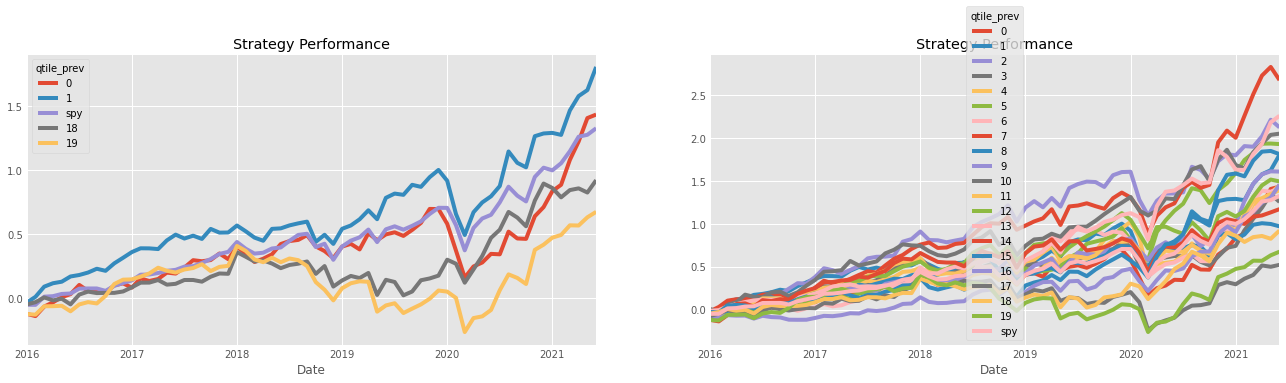

In [147]:
plt.style.use('seaborn-pastel')
plt.style.use('ggplot')

melted_rets = melting(monthly_rets, 20)
lag_rets = pd.pivot_table(melted_rets, index='Date', columns='qtile_prev', values='pchange', aggfunc=np.mean)
lag_rets['spy'] = spy_rets[spy_rets.index <= '2021-06-30']
cumrets = ((1 + lag_rets[lag_rets.index > '2016-01-01']).cumprod() - 1)

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
cumrets[ [0,1,'spy',18,19] ].plot(title='Strategy Performance',ax=ax[0])
cumrets.plot(title='Strategy Performance',ax=ax[1])
lag_rets